In [1]:
# Dependencies
import pandas as pd
import random
import numpy as np
import requests
import json
from citipy import citipy
import matplotlib.pyplot as plt
import time
import scipy.stats as st

# openweathermap API key
from config import api_key

In [2]:
# using citipy generate a list of 1000 cities evenly distributed on northern and southern hemispheres
near_lat = []
near_lng = []
city_names = []
country_codes = []
# do one loop for 500 cities in the southern hemisphere
while len(city_names)<500:
    citipy_lat = random.uniform(-90,0)
    citipy_lng = random.uniform(-180,180)
    city = citipy.nearest_city(citipy_lat,citipy_lng)
    city_name = city.city_name
    country_code = city.country_code
    if city_name not in city_names:
        near_lat.append(citipy_lat)
        near_lng.append(citipy_lng)
        city_names.append(city_name)
        country_codes.append(country_code)
# and another loop for 500 cities in the northern hemisphere
while len(city_names)<1000:
    citipy_lat = random.uniform(0,90)
    citipy_lng = random.uniform(-180,180)
    city = citipy.nearest_city(citipy_lat,citipy_lng)
    city_name = city.city_name
    country_code = city.country_code
    if city_name not in city_names:
        near_lat.append(citipy_lat)
        near_lng.append(citipy_lng)
        city_names.append(city_name)
        country_codes.append(country_code)

In [3]:
# use the lists above to create a DataFrame
cities = pd.DataFrame(list(zip(city_names,country_codes)), columns=["City", "Country"])

In [4]:
# request weather data from openweathermap 
# (url = http://api.openweathermap.org/data/2.5/weather?q={city name},{country code}&APPID={your api key}
query_url = "http://api.openweathermap.org/data/2.5/weather?q="

units = 'imperial'

# collect data from api response in these lists
lat_city = []
lng_city = []
temp = []
humidity = []
cloudiness = []
wind_speed = []
response_data = []

# store names of cities with missing data in this list
missing_field = []

# counter for api allowance of maximum 60 calls per minute
call_counter = 0

# this loops makes api requests from openweatherapi
for i in range(0,len(city_names)):
    response = requests.get(f'{query_url}{city_names[i]},{country_codes[i]}&APPID={api_key}&units={units}')
    response_data.append(response)
    weather = response.json()
    call_counter +=1
    if call_counter == 59: # wait 60 seconds every 59 requests
        time.sleep(60)
        call_counter = 0
    try:
        lat_city.append(weather["coord"]["lat"])
        lng_city.append(weather["coord"]["lon"])
        temp.append(weather["main"]["temp"])
        humidity.append(weather["main"]["humidity"])
        cloudiness.append(weather["clouds"]["all"])
        wind_speed.append(weather["wind"]["speed"])
        print(f'{i}) {city_names[i]} has weather info... adding to list!')
    except:
        missing_field.append(city_names[i])
        print(f'{i}) {city_names[i]} has missing info... skipping!')
        pass

0) hobart has weather info... adding to list!
1) port alfred has weather info... adding to list!
2) rikitea has weather info... adding to list!
3) vaini has weather info... adding to list!
4) ushuaia has weather info... adding to list!
5) mataura has missing info... skipping!
6) kilindoni has weather info... adding to list!
7) atuona has weather info... adding to list!
8) saldanha has weather info... adding to list!
9) voh has weather info... adding to list!
10) avarua has weather info... adding to list!
11) faanui has weather info... adding to list!
12) lata has missing info... skipping!
13) rio gallegos has weather info... adding to list!
14) hermanus has weather info... adding to list!
15) port elizabeth has weather info... adding to list!
16) east london has weather info... adding to list!
17) mount isa has weather info... adding to list!
18) padang has weather info... adding to list!
19) bengkulu has weather info... adding to list!
20) kaitangata has weather info... adding to list

168) esperance has weather info... adding to list!
169) kieta has weather info... adding to list!
170) moree has weather info... adding to list!
171) humaita has weather info... adding to list!
172) marcona has missing info... skipping!
173) auki has weather info... adding to list!
174) broome has weather info... adding to list!
175) kendari has weather info... adding to list!
176) sehithwa has weather info... adding to list!
177) cuamba has weather info... adding to list!
178) mporokoso has weather info... adding to list!
179) nguiu has missing info... skipping!
180) prado has weather info... adding to list!
181) hanmer springs has weather info... adding to list!
182) mahanoro has weather info... adding to list!
183) tres arroyos has weather info... adding to list!
184) molina has weather info... adding to list!
185) mareeba has weather info... adding to list!
186) byron bay has weather info... adding to list!
187) nabire has weather info... adding to list!
188) coxim has weather info

334) sungaipenuh has weather info... adding to list!
335) pontes e lacerda has weather info... adding to list!
336) waitati has weather info... adding to list!
337) loandjili has weather info... adding to list!
338) andrelandia has weather info... adding to list!
339) menongue has weather info... adding to list!
340) poya has weather info... adding to list!
341) rurrenabaque has weather info... adding to list!
342) lolua has missing info... skipping!
343) constitucion has weather info... adding to list!
344) angoram has weather info... adding to list!
345) vanimo has weather info... adding to list!
346) othaya has weather info... adding to list!
347) huambo has weather info... adding to list!
348) iringa has weather info... adding to list!
349) rodrigues alves has weather info... adding to list!
350) honiara has weather info... adding to list!
351) fare has weather info... adding to list!
352) valdivia has weather info... adding to list!
353) ambulu has weather info... adding to list!


496) kingori has weather info... adding to list!
497) palu has weather info... adding to list!
498) andevoranto has missing info... skipping!
499) jati has weather info... adding to list!
500) abha has weather info... adding to list!
501) bud has weather info... adding to list!
502) bargal has missing info... skipping!
503) nikolskoye has weather info... adding to list!
504) mier has weather info... adding to list!
505) latung has weather info... adding to list!
506) los llanos de aridane has weather info... adding to list!
507) bathsheba has weather info... adding to list!
508) barrow has weather info... adding to list!
509) koungheul has weather info... adding to list!
510) la ronge has weather info... adding to list!
511) lagoa has weather info... adding to list!
512) yellowknife has weather info... adding to list!
513) thompson has weather info... adding to list!
514) upernavik has weather info... adding to list!
515) bilibino has weather info... adding to list!
516) nizhneyansk ha

662) birjand has weather info... adding to list!
663) fort saint john has missing info... skipping!
664) havoysund has weather info... adding to list!
665) kazalinsk has missing info... skipping!
666) colares has weather info... adding to list!
667) lompoc has weather info... adding to list!
668) colwyn bay has weather info... adding to list!
669) golaghat has weather info... adding to list!
670) nanortalik has weather info... adding to list!
671) hare bay has weather info... adding to list!
672) mrirt has missing info... skipping!
673) komsomolskiy has weather info... adding to list!
674) belushya guba has missing info... skipping!
675) ojinaga has weather info... adding to list!
676) santa isabel has weather info... adding to list!
677) attawapiskat has missing info... skipping!
678) hasaki has weather info... adding to list!
679) sibu has weather info... adding to list!
680) sentyabrskiy has missing info... skipping!
681) bandarbeyla has weather info... adding to list!
682) sabang h

828) jaipur hat has missing info... skipping!
829) khasan has weather info... adding to list!
830) barinas has weather info... adding to list!
831) suhut has weather info... adding to list!
832) inuvik has weather info... adding to list!
833) galdar has weather info... adding to list!
834) liberal has weather info... adding to list!
835) odweyne has weather info... adding to list!
836) chernyshevskiy has weather info... adding to list!
837) clyde river has weather info... adding to list!
838) khash has weather info... adding to list!
839) ilulissat has weather info... adding to list!
840) riyadh has weather info... adding to list!
841) maghama has missing info... skipping!
842) floro has weather info... adding to list!
843) lang son has weather info... adding to list!
844) beckley has weather info... adding to list!
845) aktash has weather info... adding to list!
846) bibiani has weather info... adding to list!
847) dhidhdhoo has weather info... adding to list!
848) liverpool has weath

995) moose factory has weather info... adding to list!
996) makokou has weather info... adding to list!
997) grand-santi has weather info... adding to list!
998) qasigiannguit has weather info... adding to list!
999) parrita has weather info... adding to list!


In [5]:
# remove cities with missing fields from the DataFrame
cond = cities['City'].isin(missing_field)
weather_data = cities.drop(cities[cond].index)

In [6]:
# add columns for temperature, humidity, cloudiness, and wind speed to the DataFrame
weather_data["Latitude"] = lat_city
weather_data["Longitude"] = lng_city
weather_data["Temperature (F)"] = temp
weather_data["Humidity (%)"] = humidity
weather_data["Cloudiness (%)"] = cloudiness
weather_data["Wind Speed (mph)"] = wind_speed
weather_data.head()

,City,Country,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,hobart,au,-42.88,147.33,56.25,58,20,12.75
1,port alfred,za,-33.59,26.89,57.00,95,94,5.57
2,rikitea,pf,-23.12,-134.97,75.34,82,53,16.13
3,vaini,to,-21.20,-175.20,71.94,70,2,25.30
4,ushuaia,ar,-54.80,-68.30,42.80,70,40,5.82


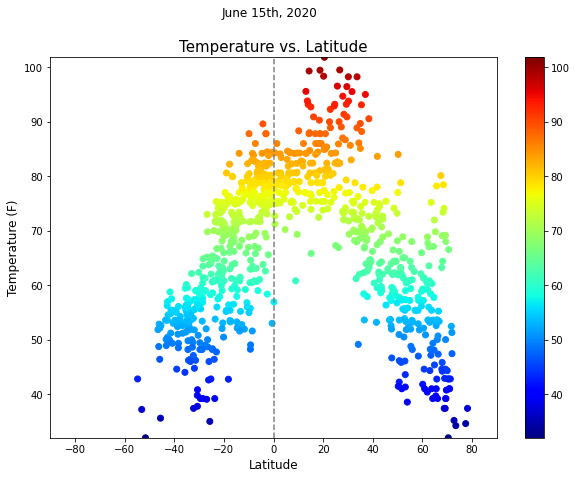

In [7]:
# make scatter plot of Temperature vs Latitude
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(
    weather_data["Latitude"],weather_data['Temperature (F)'],c=weather_data['Temperature (F)'],cmap=plt.cm.jet)
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Temperature (F)", fontsize=12)
plt.title("Temperature vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.vlines(0,weather_data['Temperature (F)'].min(),weather_data['Temperature (F)'].max(),linestyles='dashed',colors='gray')
plt.ylim(weather_data['Temperature (F)'].min(),weather_data['Temperature (F)'].max())
plt.savefig("Weather_Output/Temperature_vs_Latitude.png")
plt.show()

## Observations
### Temperature shows a warming trend towards the equator from both hemispheres, but it is skewed toward the northern hemisphere. Seing as the data represents current temperatures, in the month of June, the skew may be partly due to summer conditions in the nothern hemisphere. 
### The hottest temperatures are recorded around 20 degrees latitude north.
### The highest temperatures being recorded around 20 degrees of latitude closely approximates the axial tilt of the planet (c.23 degrees).

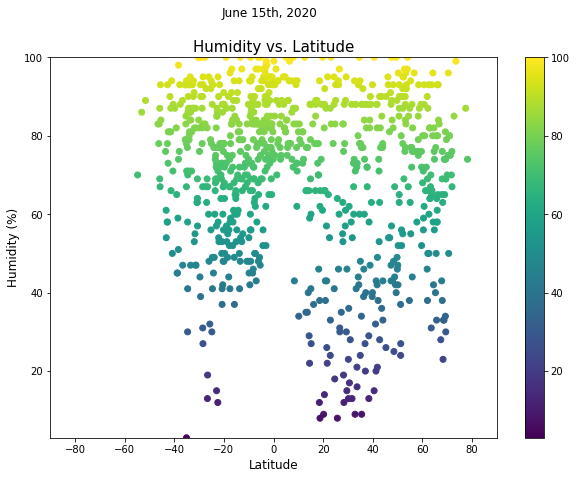

In [8]:
# make scatter plot of Humidity vs Latitude
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(weather_data["Latitude"],weather_data['Humidity (%)'],c=weather_data['Humidity (%)'])
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Humidity (%)", fontsize=12)
plt.title("Humidity vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.ylim(weather_data['Humidity (%)'].min(),weather_data['Humidity (%)'].max())
plt.savefig("Weather_Output/Humidity_vs_Latitude.png")
plt.show()

## Observations
### There is not discernible trend between latitude and current humidity.
### Places with current humidity below c. 20% are concentrated in the nothern hemisphere.

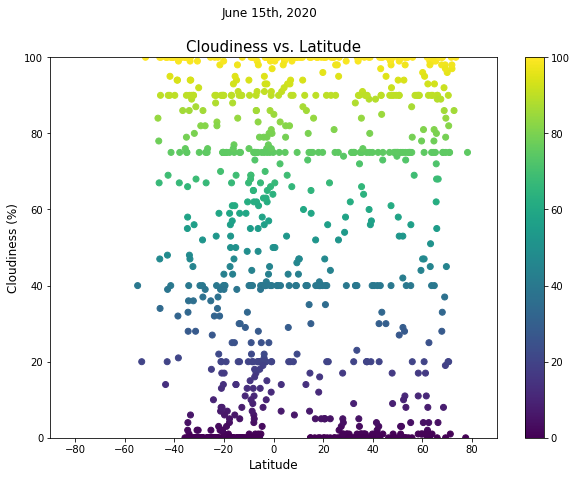

In [9]:
# make scatter plot of Cloudiness vs Latitute
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(weather_data["Latitude"],weather_data['Cloudiness (%)'],c=weather_data['Cloudiness (%)'])
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Cloudiness (%)", fontsize=12)
plt.title("Cloudiness vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.ylim(weather_data['Cloudiness (%)'].min(),weather_data['Cloudiness (%)'].max())
plt.savefig("Weather_Output/Cloudiness_vs_Latitude.png")
plt.show()

## Observations
### Cloudiness shows no discernible relationship with latitude for current weather conditions.

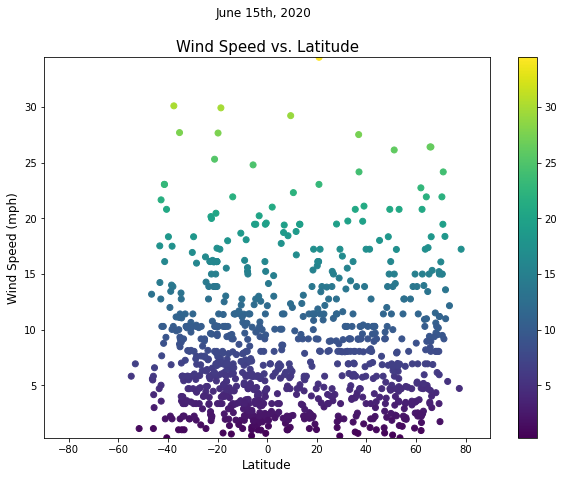

In [10]:
# make scatter plot of Wind Speed vs Latitude
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(weather_data["Latitude"],weather_data['Wind Speed (mph)'],c=weather_data['Wind Speed (mph)'])
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Wind Speed (mph)", fontsize=12)
plt.title("Wind Speed vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,90)
plt.ylim(weather_data['Wind Speed (mph)'].min(),weather_data['Wind Speed (mph)'].max())
plt.savefig("Weather_Output/WindSpeed_vs_Latitude.png")
plt.show()

## Observations
### There are no discernible trends between latitude and wind speeds  for current weather conditions.

In [11]:
# add a column to the DataFrame categorizing latitudes as northern or southern hemisphere
weather_data['Hemisphere']= ""
weather_data.loc[weather_data['Latitude']>=0,"Hemisphere"]="Northern"
weather_data.loc[weather_data['Latitude']<0,"Hemisphere"]="Southern"

# save the DataFrame to a csv file
weather_data.to_csv("Weather_Output/Weather_DataFrame.csv", index=False,header=True)

In [12]:
# create separate DataFrames for each hemisphere
northern_hemisphere = weather_data.loc[(weather_data['Hemisphere']=='Northern'),:]
southern_hemisphere = weather_data.loc[(weather_data['Hemisphere']=='Southern'),:]

r=-0.75


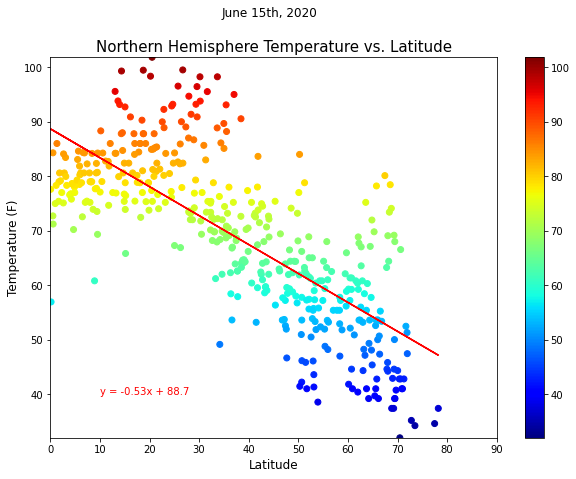

In [13]:
# plot temperature vs latitude for the northern hemisphere and add a linear regression
correlation = st.pearsonr(northern_hemisphere["Latitude"],northern_hemisphere["Temperature (F)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(northern_hemisphere["Latitude"],
                                                           northern_hemisphere["Temperature (F)"])
regress_values = northern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(
    northern_hemisphere["Latitude"],northern_hemisphere['Temperature (F)'],c=northern_hemisphere['Temperature (F)'],
    cmap=plt.cm.jet)
fig.colorbar(chart, ax=ax)
plt.plot(northern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (10,40),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Temperature (F)", fontsize=12)
plt.title("Northern Hemisphere Temperature vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(0,90)
plt.ylim(northern_hemisphere['Temperature (F)'].min(),northern_hemisphere['Temperature (F)'].max())
plt.savefig("Weather_Output/Northern_Hemisphere_Temperature.png")
plt.show()

r=0.74


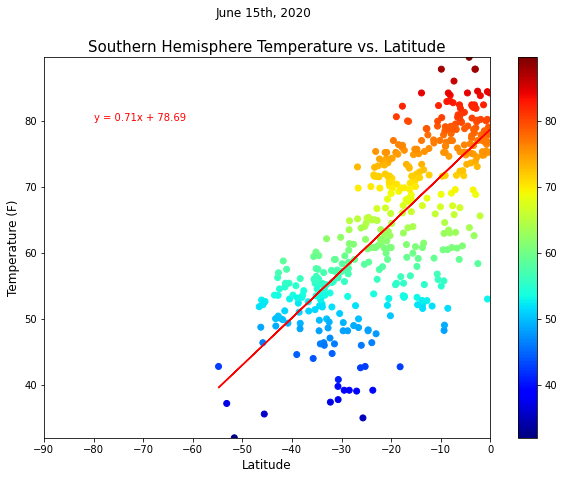

In [14]:
# plot temperature vs latitude for the southern hemisphere and add a linear regression
correlation = st.pearsonr(southern_hemisphere["Latitude"],southern_hemisphere["Temperature (F)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(southern_hemisphere["Latitude"],
                                                           southern_hemisphere["Temperature (F)"])
regress_values = southern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(
    southern_hemisphere["Latitude"],southern_hemisphere['Temperature (F)'],c=southern_hemisphere['Temperature (F)'],
    cmap=plt.cm.jet)
fig.colorbar(chart, ax=ax)
plt.plot(southern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (-80,80),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Temperature (F)", fontsize=12)
plt.title("Southern Hemisphere Temperature vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,0)
plt.ylim(southern_hemisphere['Temperature (F)'].min(),southern_hemisphere['Temperature (F)'].max())
plt.savefig("Weather_Output/Southern_Hemisphere_Temperature.png")
plt.show()

## Observations
### There is a strong correlation between temperature and latitude in both the northern and southern hemispheres. In both cases, the pearson correlation coefficient shows that over 70% of the variation in temperature is explained by latitude changes.
### In both hemispheres the temperature increases as we approach the equator.
### Data in the southern hemisphere does not extend beyond -60 degrees, likely because of the distribution of land masses on the planet and the methodology used to select the cities by proximity to randomly generated coordinates.

r=-0.08


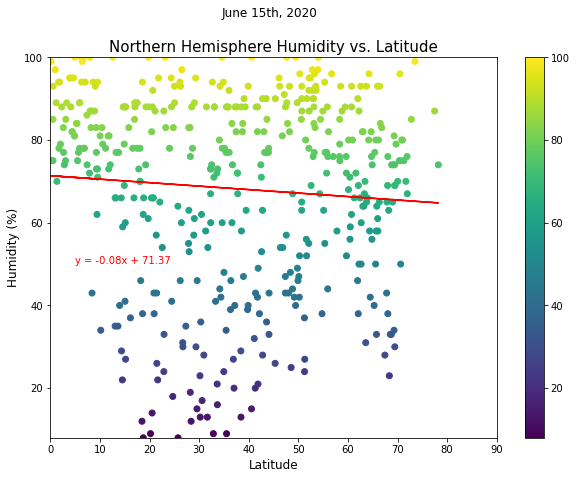

In [15]:
# plot humidity vs latitude for the northern hemisphere and add a linear regression
correlation = st.pearsonr(northern_hemisphere["Latitude"],northern_hemisphere["Humidity (%)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(northern_hemisphere["Latitude"],
                                                           northern_hemisphere["Humidity (%)"])
regress_values = northern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(northern_hemisphere["Latitude"],northern_hemisphere['Humidity (%)'],c=northern_hemisphere['Humidity (%)'])
fig.colorbar(chart, ax=ax)
plt.plot(northern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (5,50),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Humidity (%)", fontsize=12)
plt.title("Northern Hemisphere Humidity vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(0,90)
plt.ylim(northern_hemisphere['Humidity (%)'].min(),northern_hemisphere['Humidity (%)'].max())
plt.savefig("Weather_Output/Northern_Hemisphere_Humidity.png")
plt.show()

r=0.08


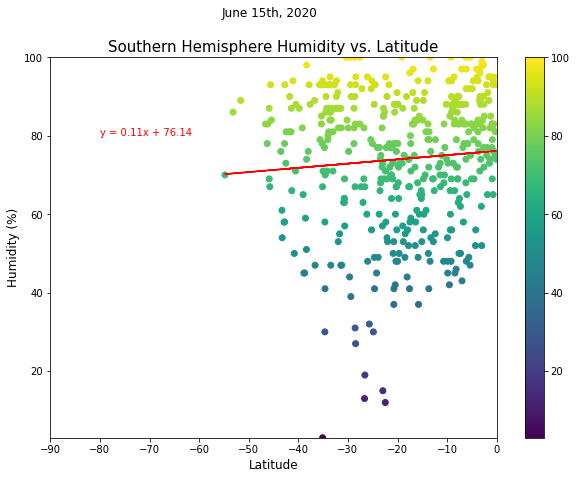

In [16]:
# plot humidity vs latitude for the southern hemisphere and add a linear regression
correlation = st.pearsonr(southern_hemisphere["Latitude"],southern_hemisphere["Humidity (%)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(southern_hemisphere["Latitude"],
                                                           southern_hemisphere["Humidity (%)"])
regress_values = southern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(southern_hemisphere["Latitude"],southern_hemisphere['Humidity (%)'],c=southern_hemisphere['Humidity (%)'])
fig.colorbar(chart, ax=ax)
plt.plot(southern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (-80,80),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Humidity (%)", fontsize=12)
plt.title("Southern Hemisphere Humidity vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,0)
plt.ylim(southern_hemisphere['Humidity (%)'].min(),southern_hemisphere['Humidity (%)'].max())
plt.savefig("Weather_Output/Southern_Hemisphere_Humidity.png")
plt.show()

## Observations
### There is no correlation between latitude and humidity in either hemisphere.

r=-0.01


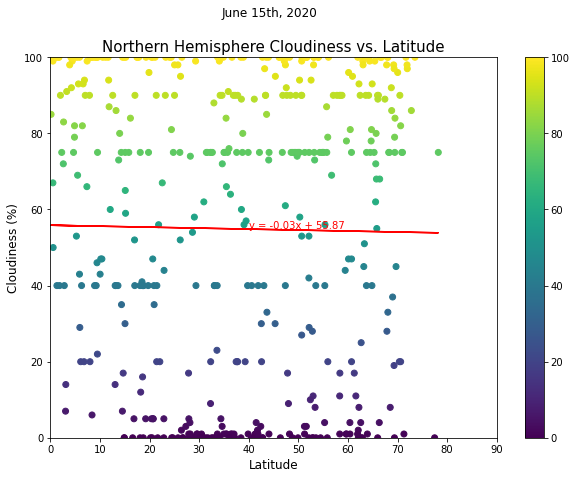

In [17]:
# plot cloudiness vs latitude for the northern hemisphere and add a linear regression
correlation = st.pearsonr(northern_hemisphere["Latitude"],northern_hemisphere["Cloudiness (%)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(northern_hemisphere["Latitude"],
                                                           northern_hemisphere["Cloudiness (%)"])
regress_values = northern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(northern_hemisphere["Latitude"],northern_hemisphere['Cloudiness (%)'],c=northern_hemisphere['Cloudiness (%)'])
fig.colorbar(chart, ax=ax)
plt.plot(northern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (40,55),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Cloudiness (%)", fontsize=12)
plt.title("Northern Hemisphere Cloudiness vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(0,90)
plt.ylim(northern_hemisphere['Cloudiness (%)'].min(),northern_hemisphere['Cloudiness (%)'].max())
plt.savefig("Weather_Output/Northern_Hemisphere_Cloudiness.png")
plt.show()

r=-0.06


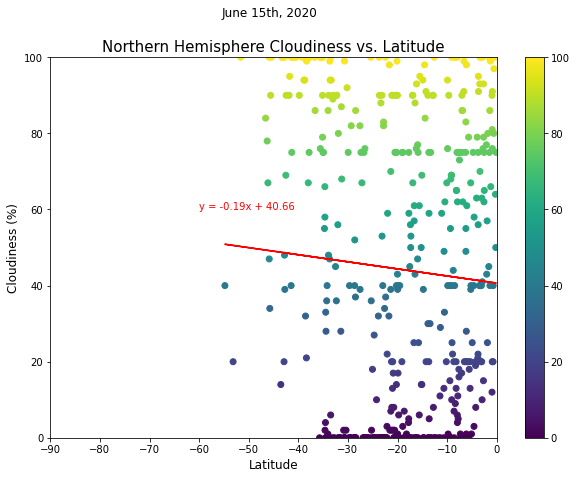

In [18]:
# plot cloudiness vs latitude for the southern hemisphere and add a linear regression
correlation = st.pearsonr(southern_hemisphere["Latitude"],southern_hemisphere["Cloudiness (%)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(southern_hemisphere["Latitude"],
                                                           southern_hemisphere["Cloudiness (%)"])
regress_values = southern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(southern_hemisphere["Latitude"],southern_hemisphere['Cloudiness (%)'],c=southern_hemisphere['Cloudiness (%)'])
fig.colorbar(chart, ax=ax)
plt.plot(southern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (-60,60),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Cloudiness (%)", fontsize=12)
plt.title("Northern Hemisphere Cloudiness vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,0)
plt.ylim(southern_hemisphere['Cloudiness (%)'].min(),southern_hemisphere['Cloudiness (%)'].max())
plt.savefig("Weather_Output/Southern_Hemisphere_Cloudiness.png")
plt.show()

## Observations
### There is no correlation between latitude and cloudiness in either hemisphere.

r=0.06


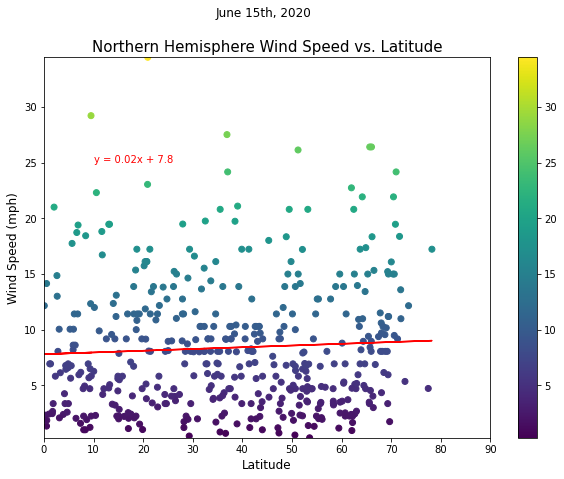

In [19]:
# plot wind speed vs latitude for the northern hemisphere and add a linear regression
correlation = st.pearsonr(northern_hemisphere["Latitude"],northern_hemisphere["Wind Speed (mph)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(northern_hemisphere["Latitude"],
                                                           northern_hemisphere["Wind Speed (mph)"])
regress_values = northern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(northern_hemisphere["Latitude"],northern_hemisphere['Wind Speed (mph)'],c=northern_hemisphere['Wind Speed (mph)'])
fig.colorbar(chart, ax=ax)
plt.plot(northern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (10,25),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Wind Speed (mph)", fontsize=12)
plt.title("Northern Hemisphere Wind Speed vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(0,90)
plt.ylim(northern_hemisphere['Wind Speed (mph)'].min(),northern_hemisphere['Wind Speed (mph)'].max())
plt.savefig("Weather_Output/Northern_Hemisphere_WindSpeed.png")
plt.show()

r=-0.15


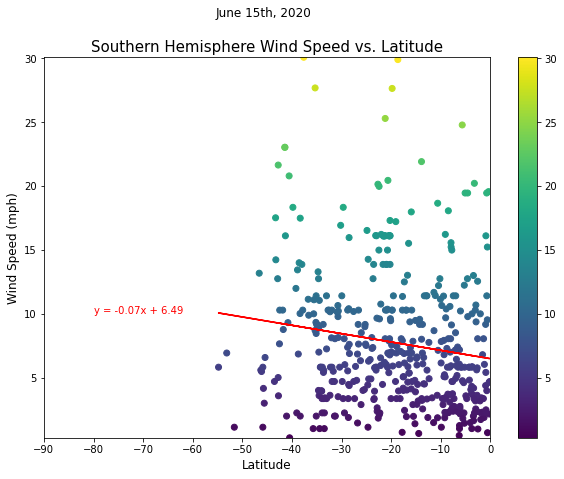

In [20]:
# plot wind speed vs latitude for the southern hemisphere and add a linear regression
correlation = st.pearsonr(southern_hemisphere["Latitude"],southern_hemisphere["Wind Speed (mph)"])
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(southern_hemisphere["Latitude"],
                                                           southern_hemisphere["Wind Speed (mph)"])
regress_values = southern_hemisphere["Latitude"] * slope + intercept
line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'
print(f'r={round(correlation[0],2)}')
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(southern_hemisphere["Latitude"],southern_hemisphere['Wind Speed (mph)'],c=southern_hemisphere['Wind Speed (mph)'])
fig.colorbar(chart, ax=ax)
plt.plot(southern_hemisphere["Latitude"], regress_values, "r-")
plt.annotate(line_eq, (-80,10),fontsize=10,color='red')
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Wind Speed (mph)", fontsize=12)
plt.title("Southern Hemisphere Wind Speed vs. Latitude", fontsize=15)
plt.suptitle("June 15th, 2020",x=0.43,fontsize=12)
plt.xlim(-90,0)
plt.ylim(southern_hemisphere['Wind Speed (mph)'].min(),southern_hemisphere['Wind Speed (mph)'].max())
plt.savefig("Weather_Output/Southern_Hemisphere_WindSpeed.png")
plt.show()

## Observations
### There is no correlation between latitude and wind speed in either hemisphere.